In [43]:
#Importando librerias necesarias para el codigo.
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, SGDClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, normaltest, anderson, probplot, pearsonr,zscore
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_recall_fscore_support, r2_score, mean_squared_error


In [44]:
#cargar el data set y revisar que si se haya guardado como data frame
#link to data set: https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation
csv_file_path = "/Users/stephgrotewold/Desktop/UFM/7Semestre/Machine Learning Models/local_24/proyecto/Occupancy_Estimation.csv"
df = pd.read_csv(csv_file_path)
df

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,2018/01/11,08:58:07,25.06,25.13,24.69,25.31,6,7,33,22,0.09,0.04,0.06,0.08,345,0.000000,0,0,0
10125,2018/01/11,08:58:37,25.06,25.06,24.69,25.25,6,7,34,22,0.07,0.05,0.05,0.08,345,0.000000,0,0,0
10126,2018/01/11,08:59:08,25.13,25.06,24.69,25.25,6,7,34,22,0.11,0.05,0.06,0.08,345,0.000000,0,0,0
10127,2018/01/11,08:59:39,25.13,25.06,24.69,25.25,6,7,34,22,0.08,0.08,0.10,0.08,345,0.000000,0,0,0


## Exploratory Data Analysis

In [45]:
#Chequear cuantas fechas distintas hay
month_counts = df['Date'].value_counts()
month_counts


Date
2017/12/23    2779
2017/12/25    1716
2017/12/22    1462
2017/12/24    1064
2017/12/26    1063
2018/01/11    1048
2018/01/10     997
Name: count, dtype: int64

In [46]:
#Revisar si hay registro para cada hora del día
hour_counts = df['Time'].value_counts()
hour_counts

Time
10:49:41    1
21:43:16    1
21:39:42    1
21:40:13    1
21:40:43    1
           ..
16:31:37    1
16:32:07    1
16:32:38    1
16:33:09    1
09:00:09    1
Name: count, Length: 10129, dtype: int64

In [47]:
df['Hour'] = pd.to_datetime(df['Time']).dt.hour

#Observaciones por hora
hour_counts = df['Hour'].value_counts()
hour_counts

/var/folders/57/c9zjxddn221c056sd800540w0000gn/T/ipykernel_1494/306525132.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour


Hour
22    466
5     465
4     465
2     465
17    465
1     465
8     464
6     464
3     464
23    464
21    464
20    464
18    463
7     463
0     460
16    460
19    451
15    413
14    347
11    344
13    333
12    315
10    255
9     250
Name: count, dtype: int64

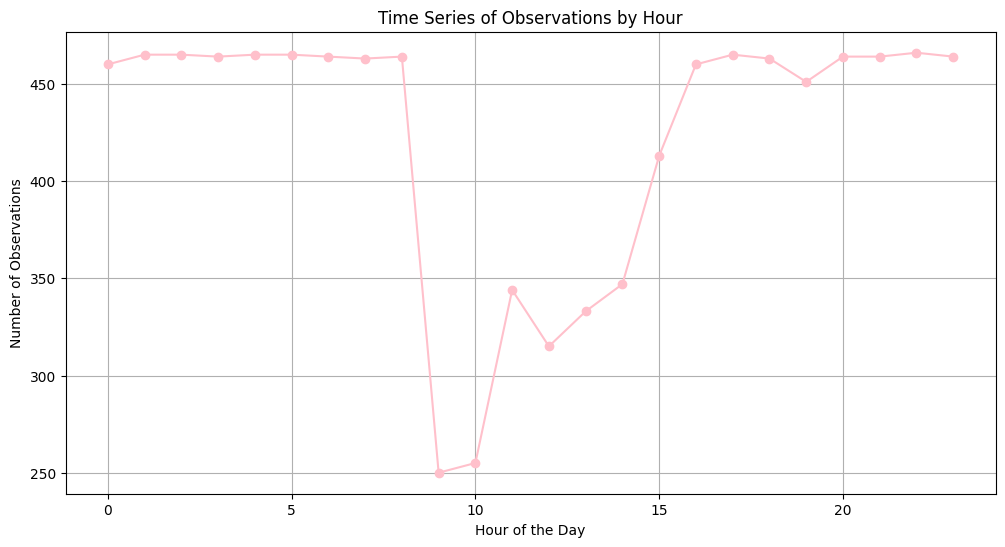

In [48]:
#Ver el comportamiento por hora graficamente
plt.figure(figsize=(12, 6))
df['Hour'].value_counts().sort_index().plot(kind='line', marker='o', color='pink')
plt.title('Time Series of Observations by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Observations')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

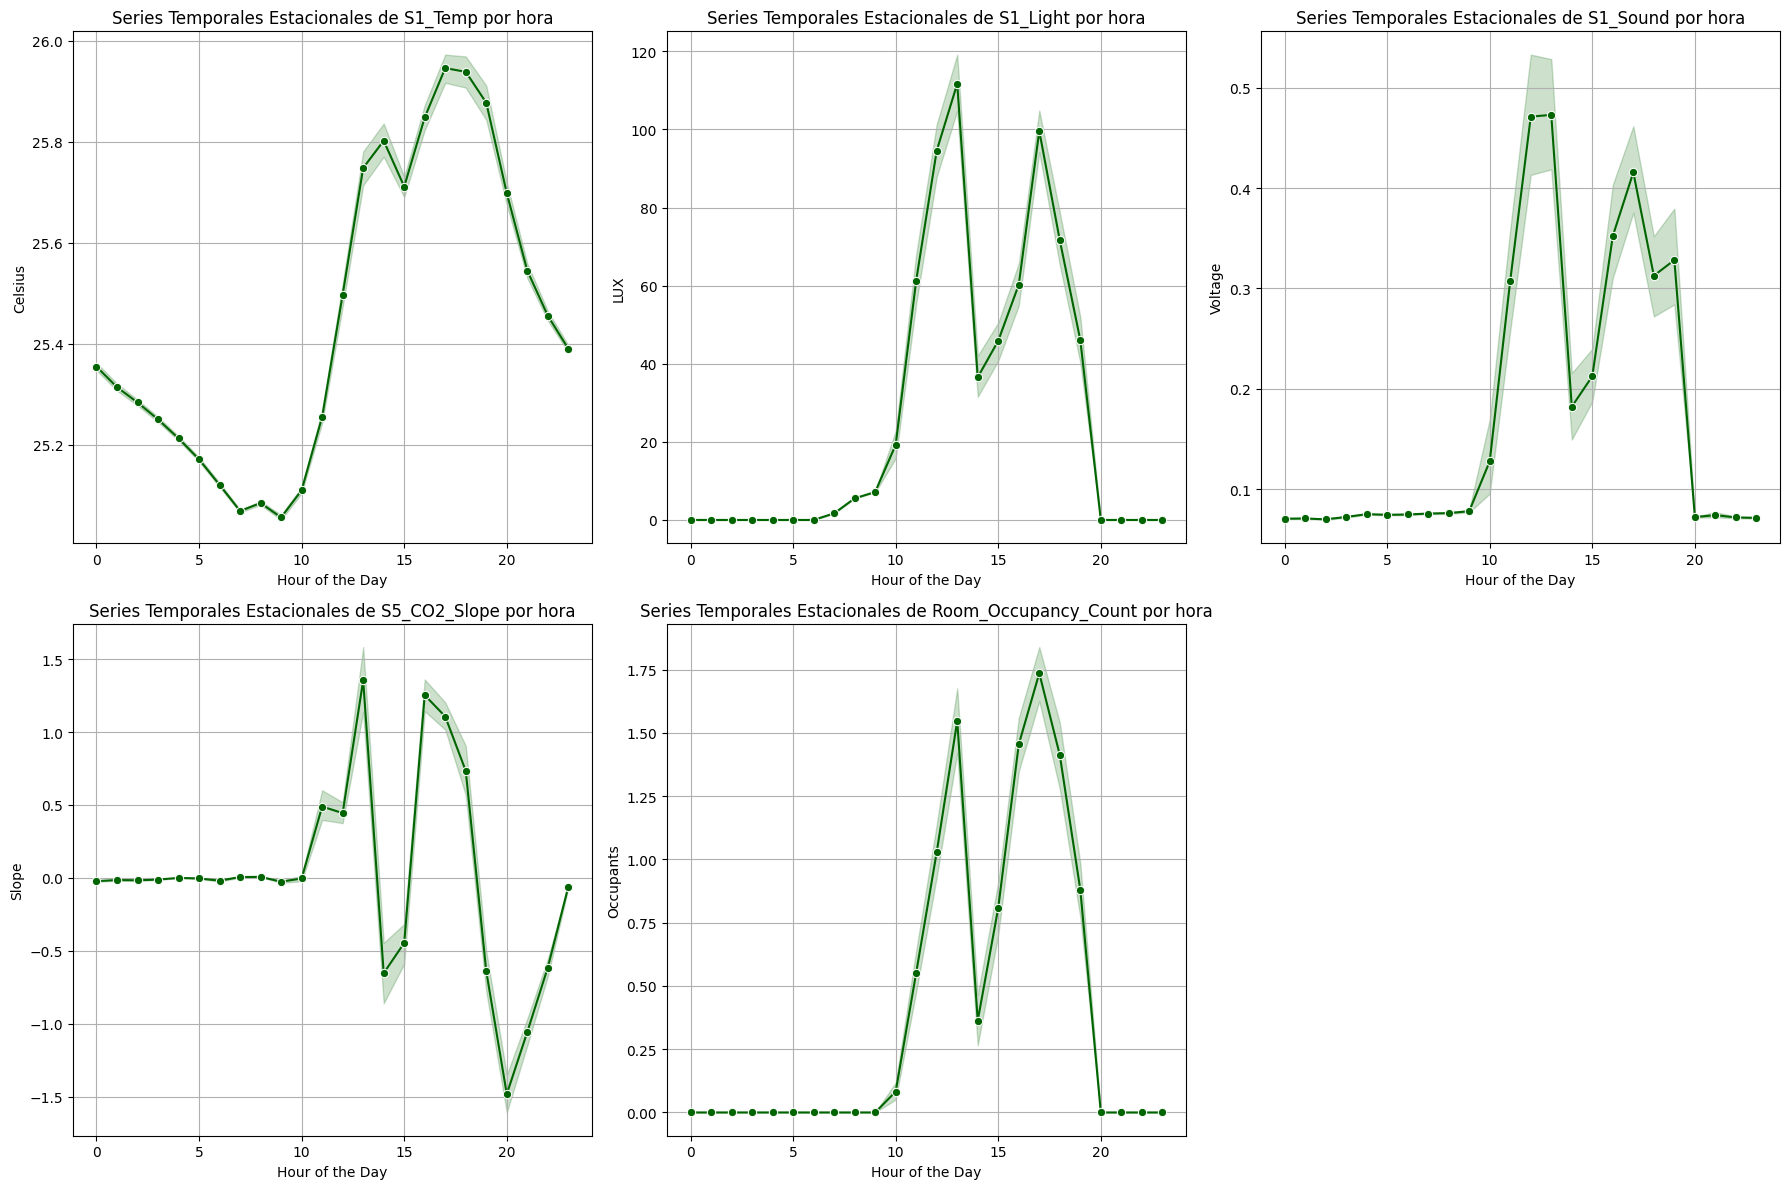

In [49]:
#Revisar los diferentes tipod de variables a comparacion de la hora
variables = ['S1_Temp', 'S1_Light', 'S1_Sound', 'S5_CO2_Slope', 'Room_Occupancy_Count']
labels = ['Celsius', 'LUX', 'Voltage', 'Slope', 'Occupants']

plt.figure(figsize=(18, 12))

for i, (variable, label) in enumerate(zip(variables, labels), 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x='Hour', y=variable, data=df, marker='o', color='darkgreen')
    plt.title(f'Series Temporales Estacionales de {variable} por hora')
    plt.xlabel('Hour of the Day')
    plt.ylabel(label)
    plt.xticks(rotation=0)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [50]:
df.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Hour
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1,10
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1,10
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1,10
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1,10
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1,10


In [51]:
df = df.drop(['Date', 'DateTime'], axis=1, errors='ignore')
df.head()
#Se quitaron ya que no hay estacionalidad en cuanto a la fecha

,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Hour
0,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1,10
1,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1,10
2,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1,10
3,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1,10
4,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1,10


In [52]:
df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Time                  10129 non-null  object 
 1   S1_Temp               10129 non-null  float64
 2   S2_Temp               10129 non-null  float64
 3   S3_Temp               10129 non-null  float64
 4   S4_Temp               10129 non-null  float64
 5   S1_Light              10129 non-null  int64  
 6   S2_Light              10129 non-null  int64  
 7   S3_Light              10129 non-null  int64  
 8   S4_Light              10129 non-null  int64  
 9   S1_Sound              10129 non-null  float64
 10  S2_Sound              10129 non-null  float64
 11  S3_Sound              10129 non-null  float64
 12  S4_Sound              10129 non-null  float64
 13  S5_CO2                10129 non-null  int64  
 14  S5_CO2_Slope          10129 non-null  float64
 15  S6_PIR             

In [53]:
#Revisar cuantos nulos hay en el data set
df.isnull().sum()

Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
Hour                    0
dtype: int64

In [54]:
print("\nDataset shape:")
print(df.shape)


Dataset shape:
(10129, 19)


In [55]:
df.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Hour
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559,11.508639
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633,7.228631
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000,5.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000,12.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000,18.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000,23.000000


In [56]:
#Seleccionar las columnas numéricas del DataFrame
numeric_columns = df.select_dtypes(include='number').columns

#Calcular el Z-score para las columnas numéricas
z_scores = zscore(df[numeric_columns])

#Crear un DataFrame con los Z-scores y nombres de las columnas
z_scores_df = pd.DataFrame(z_scores, columns=numeric_columns)

#Establecer un umbral para identificar outliers basados en el Z-score
threshold = 3

#Crear un DataFrame booleano que indica True para outliers
outliers = (z_scores_df > threshold) | (z_scores_df < -threshold)

#Mostrar las filas del DataFrame original que tienen outliers
print(df[outliers.any(axis=1)])

          Time  S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  S2_Light  \
6     10:52:45    25.00    24.75    24.56    25.44       120        34   
9     10:54:17    25.00    24.81    24.56    25.50       101        34   
10    10:54:47    25.06    24.81    24.56    25.44       122        35   
11    10:55:18    25.06    24.81    24.56    25.50       123        35   
12    10:55:49    25.06    24.88    24.63    25.50       123        35   
...        ...      ...      ...      ...      ...       ...       ...   
8375  17:55:55    26.00    26.25    25.75    25.94       141       227   
8376  17:56:25    25.94    26.31    25.75    25.94       141       226   
8377  17:56:56    26.00    26.25    25.75    26.00       141       226   
8378  17:57:27    25.94    26.31    25.75    25.94         0         0   
8379  17:57:57    25.94    26.25    25.69    26.00         0         0   

      S3_Light  S4_Light  S1_Sound  S2_Sound  S3_Sound  S4_Sound  S5_CO2  \
6           54        40      1.39 

In [57]:
#Revisar cuantos valores unicos y cuales son de las variables de light
light_columns = ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']

for col in light_columns:
    unique_counts = df[col].value_counts()
    print(f"Unique values in {col}:\n{unique_counts}\n")

Unique values in S1_Light:
S1_Light
0      5845
6       333
5       278
10      218
14      198
       ... 
93        1
153       1
107       1
112       1
144       1
Name: count, Length: 68, dtype: int64

Unique values in S2_Light:
S2_Light
0      5846
6       268
7       226
5       222
20      208
       ... 
220       1
207       1
185       1
200       1
258       1
Name: count, Length: 82, dtype: int64

Unique values in S3_Light:
S3_Light
0      5591
180     178
32      110
75       99
35       94
       ... 
271       1
250       1
261       1
215       1
169       1
Name: count, Length: 177, dtype: int64

Unique values in S4_Light:
S4_Light
0     5599
10     325
7      201
20     176
21     168
      ... 
66       7
69       7
67       6
64       5
68       2
Name: count, Length: 75, dtype: int64



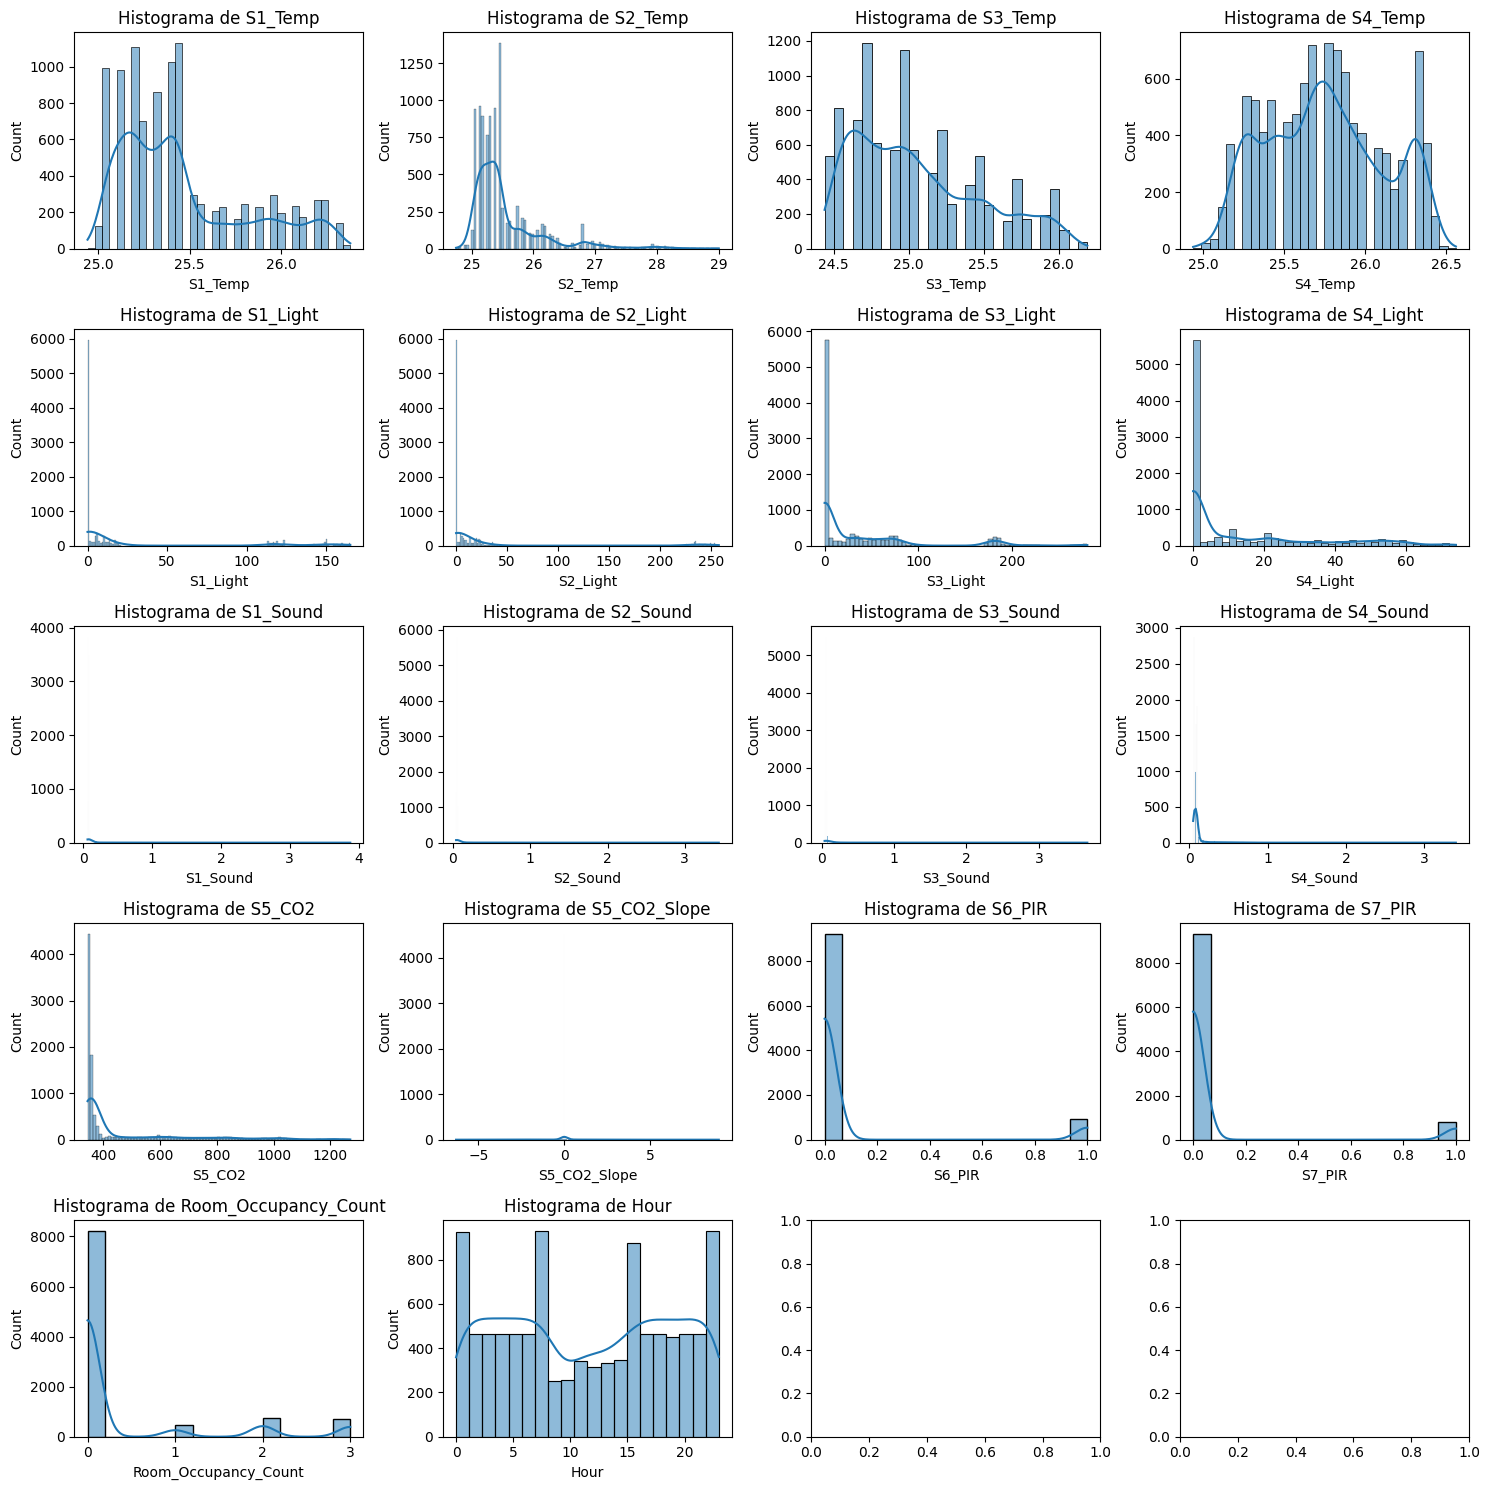

In [58]:
#Calcular el número de filas y columnas necesarias en función del número de columnas numéricas
num_cols = len(numeric_columns)
num_rows = (num_cols - 1) // 4 + 1  #Ajustar el número de columnas según sea necesario

#Crear una cuadrícula de subgráficos
fig, axes = plt.subplots(num_rows, 4, figsize=(15, 3 * num_rows))

#Aplanar el array de ejes
axes = axes.flatten()

#Iterar a través de las columnas numéricas y crear histogramas
for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Histograma de {col}')

plt.tight_layout()
plt.show()

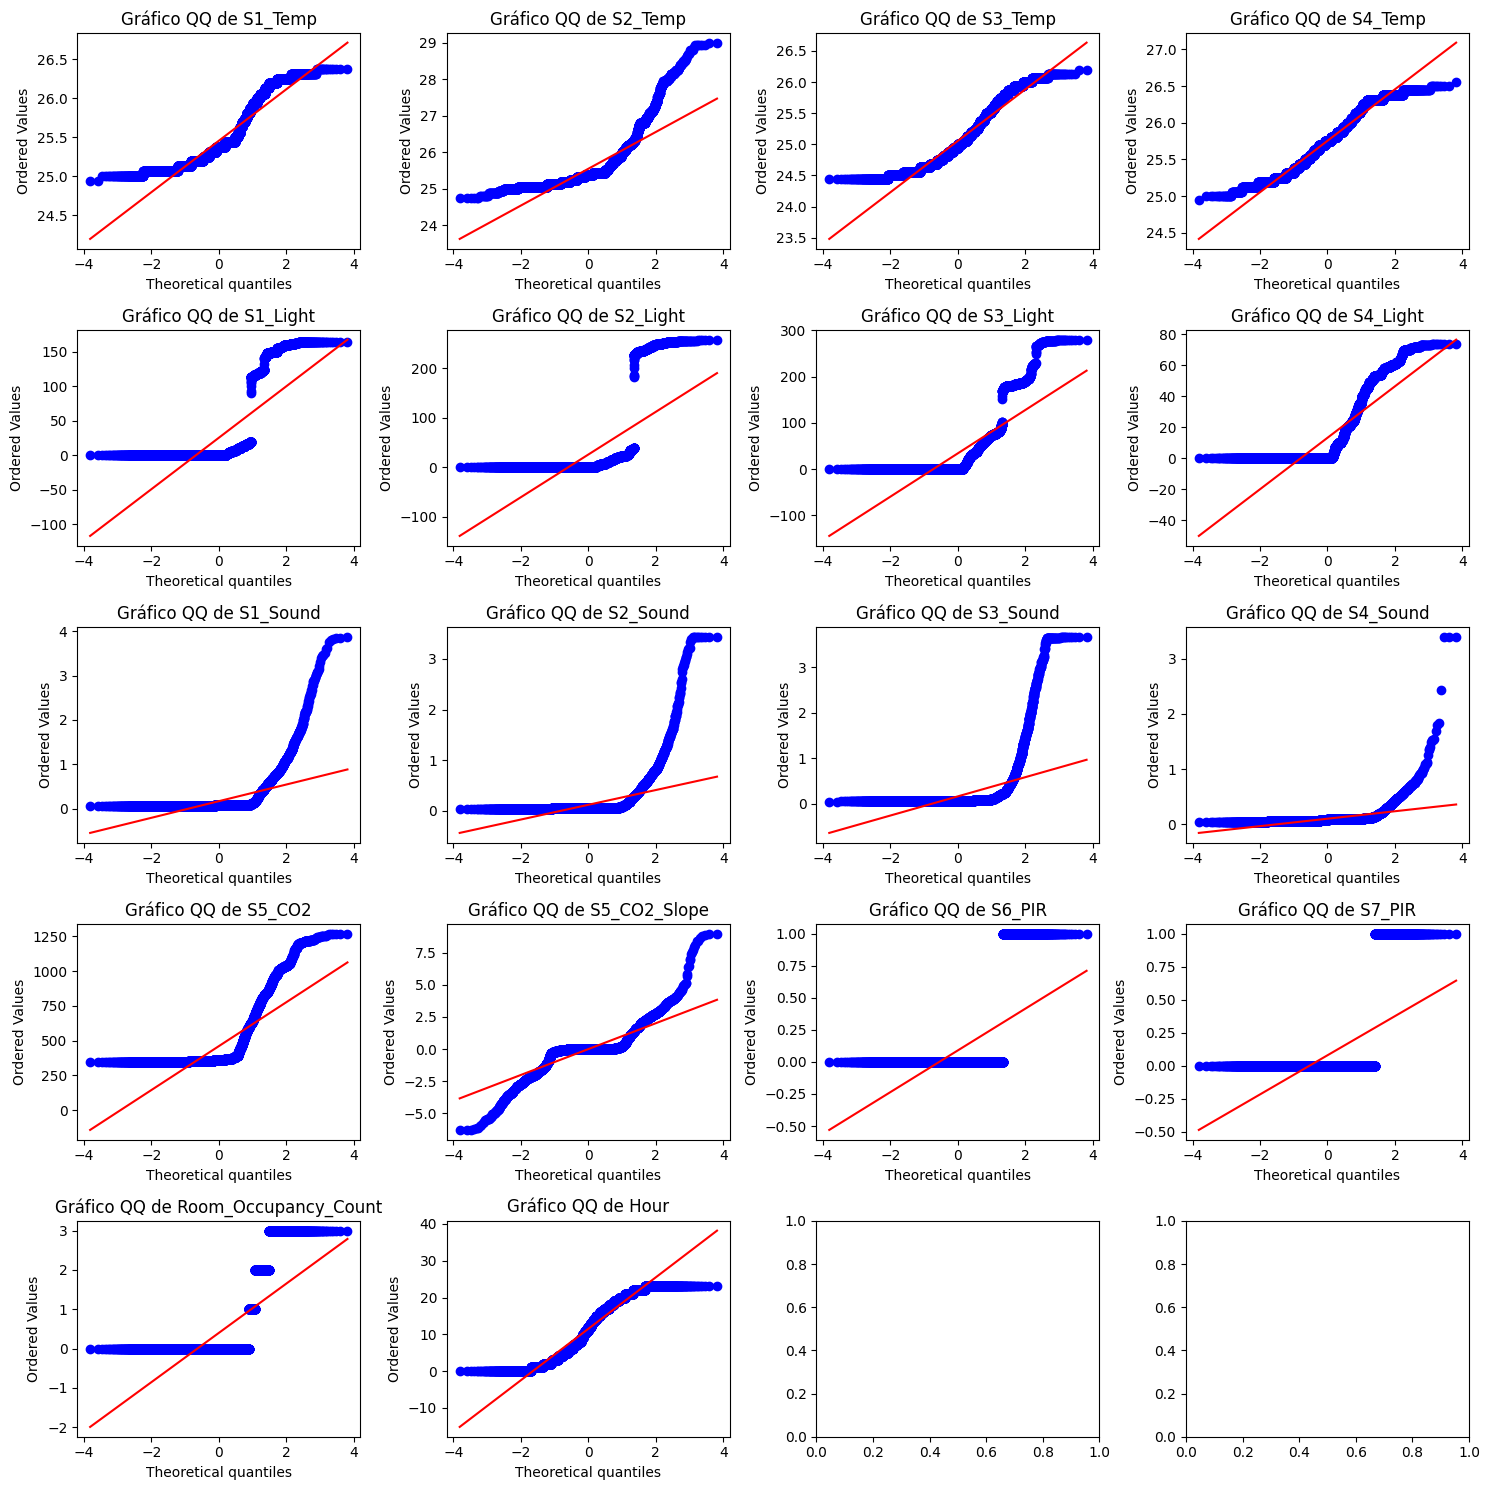

In [59]:
#Calcular el número de filas y columnas necesarias en función del número de columnas numéricas
num_cols = len(numeric_columns)
num_rows = (num_cols - 1) // 4 + 1  #Ajustar el número de columnas según sea necesario

#Crear una cuadrícula de subgráficos
fig, axes = plt.subplots(num_rows, 4, figsize=(15, 3 * num_rows))

#Aplanar el array de ejes
axes = axes.flatten()

#Iterar a través de las columnas numéricas y crear gráficos QQ
for i, col in enumerate(numeric_columns):
    probplot(df[col], plot=axes[i])
    axes[i].set_title(f'Gráfico QQ de {col}')

plt.tight_layout()
plt.show()

In [60]:
for col in df.select_dtypes(include='number').columns:
    print(f"\nNormality test results for {col}:")
    _, p_normaltest = normaltest(df[col])
    result_anderson = anderson(df[col])
    
    print(f"D'Agostino's K^2 Test p-value: {p_normaltest}")
    print(f"Anderson-Darling Test Statistic: {result_anderson.statistic}")
    print(f"Anderson-Darling Critical Values: {result_anderson.critical_values}")

#D'Agostino's K^2 Test p-value: In all the results, the p-value is 0.0. 
#This indicates that we can reject the null hypothesis of normality at a significance level of 0.05.


Normality test results for S1_Temp:
D'Agostino's K^2 Test p-value: 7.447617004329695e-246
Anderson-Darling Test Statistic: 422.3430084666361
Anderson-Darling Critical Values: [0.576 0.656 0.787 0.918 1.092]

Normality test results for S2_Temp:
D'Agostino's K^2 Test p-value: 0.0
Anderson-Darling Test Statistic: 817.5628533820345
Anderson-Darling Critical Values: [0.576 0.656 0.787 0.918 1.092]

Normality test results for S3_Temp:
D'Agostino's K^2 Test p-value: 4.207950758444999e-185
Anderson-Darling Test Statistic: 199.05018303131328
Anderson-Darling Critical Values: [0.576 0.656 0.787 0.918 1.092]

Normality test results for S4_Temp:
D'Agostino's K^2 Test p-value: 0.0
Anderson-Darling Test Statistic: 77.78835785198316
Anderson-Darling Critical Values: [0.576 0.656 0.787 0.918 1.092]

Normality test results for S1_Light:
D'Agostino's K^2 Test p-value: 0.0
Anderson-Darling Test Statistic: 2287.5374525588413
Anderson-Darling Critical Values: [0.576 0.656 0.787 0.918 1.092]

Normality tes

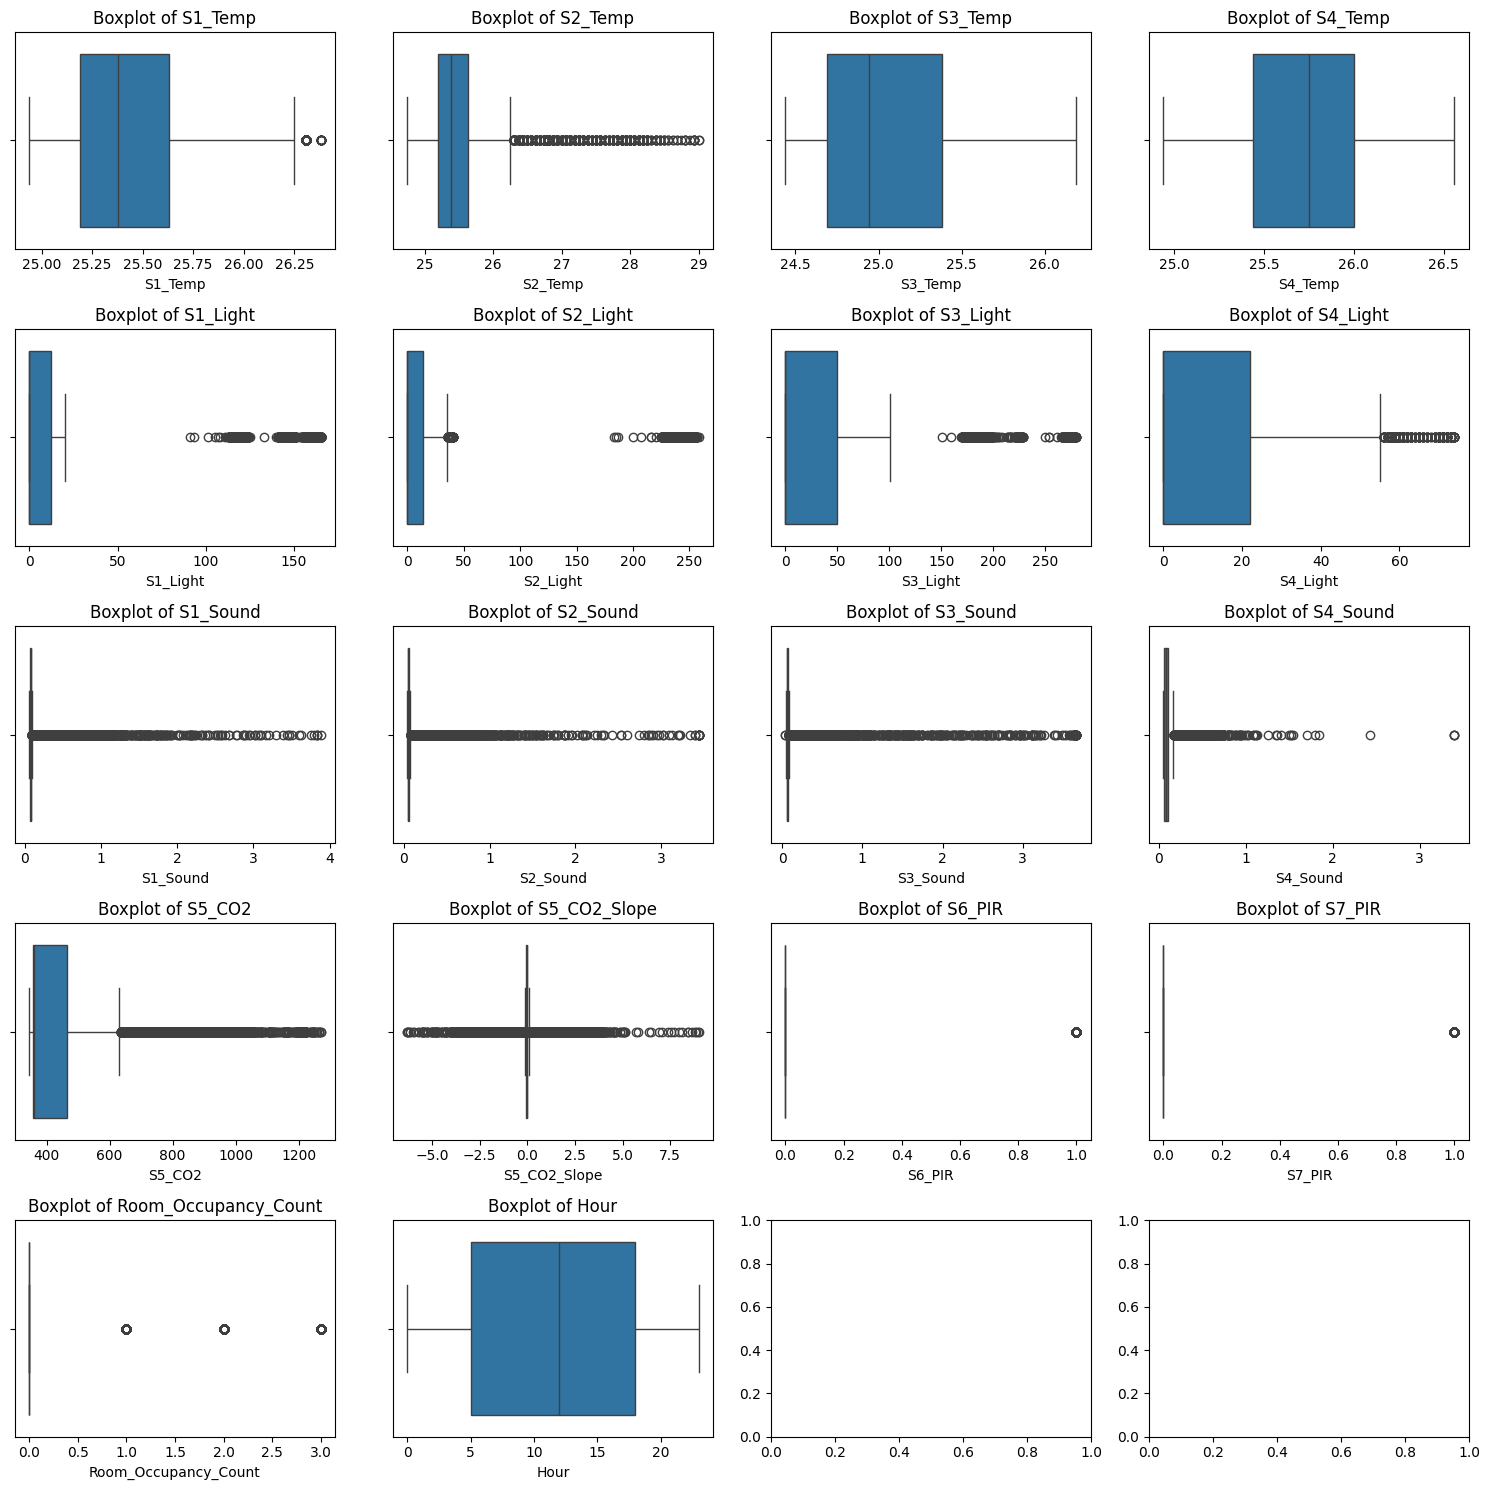

In [61]:
#Realizar boxplot de las variables para ver outliers 
num_cols = len(numeric_columns)
num_rows = (num_cols - 1) // 4 + 1  

fig, axes = plt.subplots(num_rows, 4, figsize=(15, 3 * num_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

## Matriz de Correlación

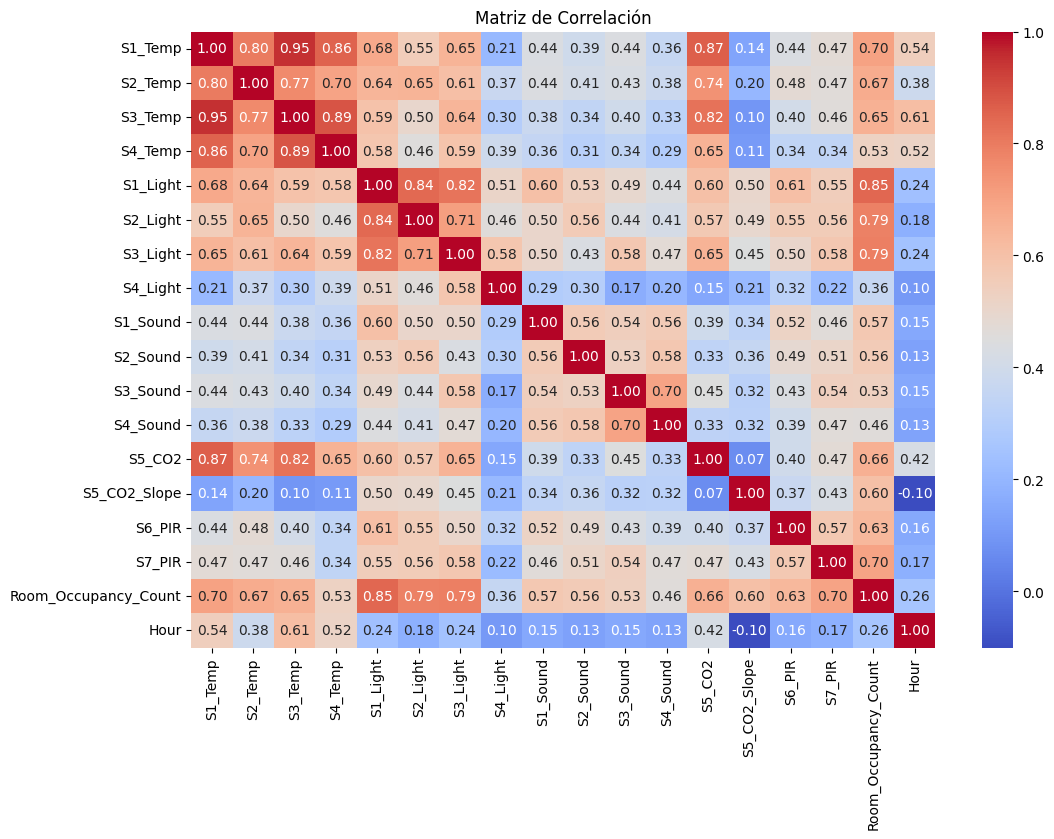

In [62]:
#Eliminar columnas no numéricas (suponiendo que 'timestamp' es una columna no numérica)
numeric_df = df.select_dtypes(include='number')

#Calcular la matriz de correlación
correlation_matrix = numeric_df.corr()

#Graficar el mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

## Variance Inflation Factor (VIF)

In [63]:
#conjunto de datos con las variables predictoras
X = df[['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 
        'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light',
          'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
            'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']]

#Agrega una columna constante si no tienes una
X_with_const = sm.add_constant(X)

#Calcula el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

print(vif_data)

        Variable           VIF
0          const  32617.598959
1        S1_Temp     29.527230
2        S2_Temp      4.075899
3        S3_Temp     18.443998
4        S4_Temp      6.400014
5       S1_Light      9.904918
6       S2_Light      5.148298
7       S3_Light      6.322680
8       S4_Light      3.138559
9       S1_Sound      2.086428
10      S2_Sound      2.213428
11      S3_Sound      2.651366
12      S4_Sound      2.338866
13        S5_CO2      6.767583
14  S5_CO2_Slope      1.937009
15        S6_PIR      1.982979
16        S7_PIR      2.214716


In [64]:
target_variable = 'Room_Occupancy_Count'

#Variables numéricas de interés
numeric_variables = ['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']

#Calcular la correlación entre variables numéricas y la variable objetivo
correlations = {}
for var in numeric_variables:
    corr, _ = pearsonr(df[var], df[target_variable])
    correlations[var] = corr

print("Correlaciones:")
for var, corr in correlations.items():
    print(f"{var}: {corr}")

#Realizar regresión lineal para cada variable numérica
for var in numeric_variables:
    model = LinearRegression()
    X = df[[var]]
    y = df[target_variable]
    model.fit(X, y)
    coef = model.coef_[0]
    print(f"Regresión Lineal - Variable: {var}, Coeficiente: {coef}")

import statsmodels.api as sm

X = df[['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']]
y = df['Room_Occupancy_Count']

#Añadir una constante para el término de intercepción
X = sm.add_constant(X)

#Ajustar el modelo de regresión lineal
model = sm.OLS(y, X).fit()

#Imprimir un resumen del modelo que incluye p-values e intervalos de confianza
print(model.summary())


Correlaciones:
S1_Temp: 0.7008681816112003
S2_Temp: 0.6712634874725059
S3_Temp: 0.6520465675239184
S4_Temp: 0.5265086555834051
S1_Light: 0.849058052303812
S2_Light: 0.7887638773829779
S3_Light: 0.7930813168052001
S4_Light: 0.3557147404498817
S1_Sound: 0.5737482916456577
S2_Sound: 0.5578530448115928
S3_Sound: 0.5316848559796175
S4_Sound: 0.4602873459008359
S5_CO2: 0.660144495152539
S5_CO2_Slope: 0.6011050011064121
S6_PIR: 0.6331328743786737
S7_PIR: 0.6951375262806372
Regresión Lineal - Variable: S1_Temp, Coeficiente: 1.7826042538104026
Regresión Lineal - Variable: S2_Temp, Coeficiente: 1.0230892291478626
Regresión Lineal - Variable: S3_Temp, Coeficiente: 1.3637122209968695
Regresión Lineal - Variable: S4_Temp, Coeficiente: 1.3200352762598986
Regresión Lineal - Variable: S1_Light, Coeficiente: 0.01487409440507521
Regresión Lineal - Variable: S2_Light, Coeficiente: 0.010472835272586923
Regresión Lineal - Variable: S3_Light, Coeficiente: 0.012135525150382588
Regresión Lineal - Variable: S4

In [65]:
original = df
variables_to_drop = ['S1_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S3_Light','S5_CO2', 'Time']

#Drop the specified variables from the DataFrame
df = df.drop(variables_to_drop, axis=1)
df.head()

,S2_Temp,S2_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Hour
0,24.75,34,40,0.08,0.19,0.06,0.06,0.769231,0,0,1,10
1,24.75,33,40,0.93,0.05,0.06,0.06,0.646154,0,0,1,10
2,24.75,34,40,0.43,0.11,0.08,0.06,0.519231,0,0,1,10
3,24.75,34,40,0.41,0.10,0.10,0.09,0.388462,0,0,1,10
4,24.75,34,40,0.18,0.06,0.06,0.06,0.253846,0,0,1,10


# Revisar el *balance* del data set

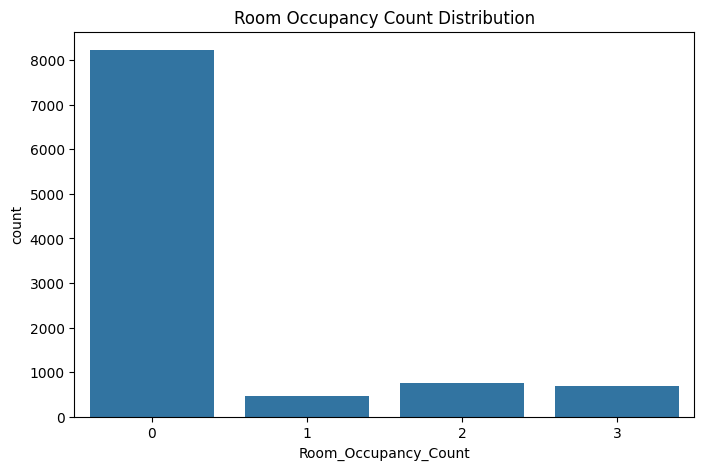

In [66]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Room_Occupancy_Count', data=df)
plt.title('Room Occupancy Count Distribution')
plt.show()

In [67]:
#Ver cuantas observaciones por cada categoria
unique_values_count = df['Room_Occupancy_Count'].value_counts()
print(unique_values_count)

Room_Occupancy_Count
0    8228
2     748
3     694
1     459
Name: count, dtype: int64


Room_Occupancy_Count
0    8228
2    3259
3    2945
1    2024
Name: count, dtype: int64


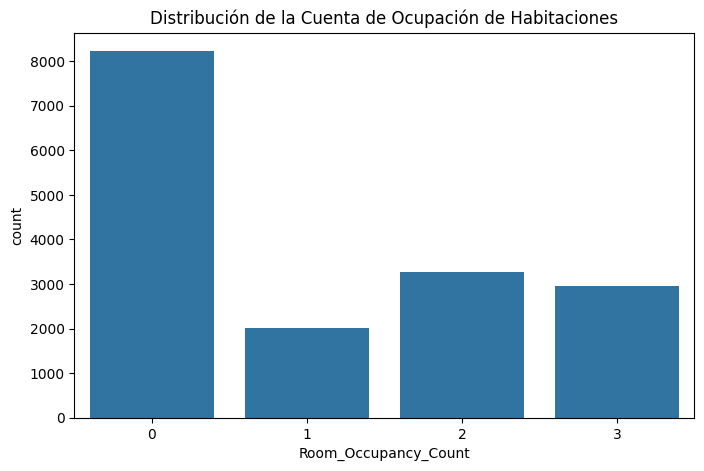

In [68]:
#Definir la clase mayoritaria (0 en este caso)
majority_class = 0  

#Separar las clases mayoritarias y minoritarias
majority_data = df[df['Room_Occupancy_Count'] == majority_class]
minority_data = df[df['Room_Occupancy_Count'] != majority_class]

#Realizar un remuestreo de las clases minoritarias para igualar el recuento de la clase mayoritaria
minority_upsampled = resample(minority_data, replace=True, n_samples=len(majority_data), random_state=42)

#Combinar la clase mayoritaria con la clase minoritaria remuestreada
balanced_df = pd.concat([majority_data, minority_upsampled])

#Verificar la distribución de clases después del balanceo
print(balanced_df['Room_Occupancy_Count'].value_counts())

#Visualizar la distribución de la cuenta de ocupación de habitaciones
plt.figure(figsize=(8, 5))
sns.countplot(x='Room_Occupancy_Count', data=balanced_df)
plt.title('Distribución de la Cuenta de Ocupación de Habitaciones')
plt.show()

Room_Occupancy_Count
0    8228
2    6468
3    5946
1    4042
Name: count, dtype: int64


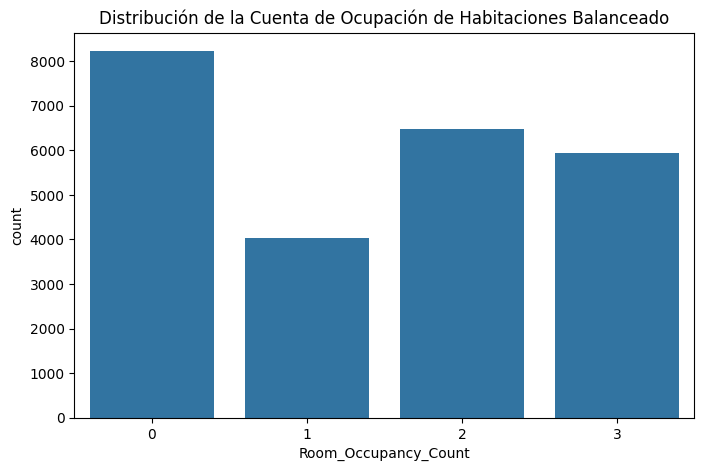

In [69]:
majority_class = 0  #La clase mayoritaria en tu columna 'Room_Occupancy_Count'

#Separar las clases mayoritarias y minoritarias
majority_data = df[df['Room_Occupancy_Count'] == majority_class]
minority_data = df[df['Room_Occupancy_Count'] != majority_class]

#Remuestrear las clases minoritarias para igualar el recuento de la clase mayoritaria (aumentando el factor a 2)
minority_upsampled = resample(minority_data, replace=True, n_samples=2 * len(majority_data), random_state=42)

#Combinar la clase mayoritaria con la clase minoritaria remuestreada
balanced_df = pd.concat([majority_data, minority_upsampled])

#Verificar la distribución de clases después del balanceo
unique_values_count_balanced = balanced_df['Room_Occupancy_Count'].value_counts()
print(unique_values_count_balanced)

#Visualizar la distribución de la cuenta de ocupación de habitaciones
plt.figure(figsize=(8, 5))
sns.countplot(x='Room_Occupancy_Count', data=balanced_df)
plt.title('Distribución de la Cuenta de Ocupación de Habitaciones Balanceado')
plt.show()

# Algoritmos de Clasificación
## sklearn.linear_model.SGDClassifier

In [70]:
#Selecciona las características (X) y la variable objetivo (y) del conjunto de datos balanceado
X_sdg = balanced_df.drop('Room_Occupancy_Count', axis=1)
y_sdg = balanced_df['Room_Occupancy_Count']

#Divide los datos balanceados en conjuntos de entrenamiento y validación
X_train_sdg, X_test_sdg, y_train_sdg, y_test_sdg = train_test_split(
    X_sdg, y_sdg, test_size=0.3, random_state=42
)

#Crea un pipeline que incluye el escalado y el clasificador
pipeline = Pipeline([
    ('scaler', StandardScaler()),  #Escalador para normalizar los datos
    ('classifier', SGDClassifier(loss='log_loss', random_state=42))  #Clasificador SGD con regresión logística
])

#Entrena el pipeline (ajusta el escalador y el clasificador) con los datos de entrenamiento
pipeline.fit(X_train_sdg, y_train_sdg)

#Realiza predicciones en el conjunto de validación
y_pred_sdg = pipeline.predict(X_test_sdg)

### Evaluación de Modelo 

In [71]:
#Evalúa el clasificador
accuracy_balanced = accuracy_score(y_test_sdg, y_pred_sdg)
conf_matrix_balanced = confusion_matrix(y_test_sdg, y_pred_sdg)
class_report_balanced = classification_report(y_test_sdg, y_pred_sdg)

print("\nConfusion Matrix:")
print(conf_matrix_balanced)
print("\nClassification Report:")
print(class_report_balanced)

#Calcula precisión, sensibilidad y puntuación F1 (ponderada para clasificación multiclase)
precision_balanced, recall_balanced, f1_score_balanced, _ = precision_recall_fscore_support(
    y_test_sdg, y_pred_sdg, average='weighted'
)
print(f'Accuracy: {accuracy_balanced * 100:.2f}%')
print(f"Precision: {precision_balanced *100:.2f}%")
print(f"Recall: {recall_balanced * 100:.2f}%")
print(f"F1 Score: {f1_score_balanced*100:.2f}%")

#Métricas adicionales para regresión
mse = mean_squared_error(y_test_sdg, y_pred_sdg)
print(f"Mean Squared Error: {mse}")

r_squared = r2_score(y_test_sdg, y_pred_sdg)
print(f'R^2: {r_squared*100:.2f}%')

n = len(y_test_sdg)
numero_columns = df.shape[1]
k = numero_columns - 1  #Resta 1 porque 'Room_Occupancy_Count' está en el df
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
print(f'R^2 Ajustado: {adjusted_r_squared * 100:.2f}%')


Confusion Matrix:
[[2403   47    0    5]
 [  24 1132   59    6]
 [  59  116 1328  424]
 [  14  121  368 1300]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2455
           1       0.80      0.93      0.86      1221
           2       0.76      0.69      0.72      1927
           3       0.75      0.72      0.73      1803

    accuracy                           0.83      7406
   macro avg       0.82      0.83      0.82      7406
weighted avg       0.83      0.83      0.83      7406

Accuracy: 83.22%
Precision: 82.97%
Recall: 83.22%
F1 Score: 82.97%
Mean Squared Error: 0.2637051039697543
R^2: 81.07%
R^2 Ajustado: 81.04%


In [72]:
#Crea un pipeline con escalado y clasificador
start = time.time()
sgd_classifier = make_pipeline(StandardScaler(), SGDClassifier(loss='log_loss', random_state=42))

#Escala los datos de entrenamiento
X_train_scaled_sdg = StandardScaler().fit_transform(X_train_sdg.astype(np.float64))
y_train_sdg = y_train_sdg.astype(np.float64)  #Asegura que la variable objetivo esté en el formato correcto

#Entrena sobre todo el conjunto de datos balanceado
sgd_cross_scores_balanced = cross_val_score(sgd_classifier, X_train_scaled_sdg, y_train_sdg, cv=5, scoring="accuracy")

print('Training completed in: {0} Min.'.format(round((time.time()-start)/60, 2)))
print('Cross-Validation Scores (Balanced):', sgd_cross_scores_balanced)

Training completed in: 0.01 Min.
Cross-Validation Scores (Balanced): [0.84519676 0.83709491 0.81568287 0.83328509 0.8301013 ]


In [73]:
#Obtén las probabilidades predichas por el clasificador en el conjunto de validación balanceado
sgd_clf_probs = pipeline.predict_proba(X_test_sdg)
sgd_clf_probs

array([[1.47697706e-27, 1.63571832e-02, 2.00779222e-01, 7.82863595e-01],
       [2.34478319e-02, 6.00932813e-01, 1.25281237e-01, 2.50338118e-01],
       [4.83991477e-22, 3.70785036e-07, 9.95309484e-01, 4.69014560e-03],
       ...,
       [2.36006925e-21, 1.39777116e-01, 4.67699956e-01, 3.92522928e-01],
       [7.33353844e-01, 3.50863825e-02, 2.16662889e-01, 1.48968842e-02],
       [4.04606776e-05, 1.89891509e-03, 7.66667274e-01, 2.31393350e-01]])

In [74]:
start = time.time()

#Obtiene los datos predichos del entrenamiento mediante validación cruzada sobre el conjunto de datos balanceado
y_train_pred_sdg = cross_val_predict(sgd_classifier, X_train_scaled_sdg, y_train_sdg, cv=3)

#Asegura que las dimensiones coincidan utilizando los mismos índices para y_train_sdg y y_train_pred_sdg
y_train_pred_sdg = y_train_pred_sdg[:len(y_train_sdg)]

#Calcula la matriz de confusión
conf_mx_balanced = confusion_matrix(y_train_sdg, y_train_pred_sdg)

print('Training completed in: {0} Min.'.format(round((time.time()-start)/60, 2)))
print('Confusion Matrix (Balanced):', conf_mx_balanced)

Training completed in: 0.01 Min.
Confusion Matrix (Balanced): [[5619  145    6    3]
 [  55 2545  146   75]
 [ 133  181 2863 1364]
 [  40  205  548 3350]]


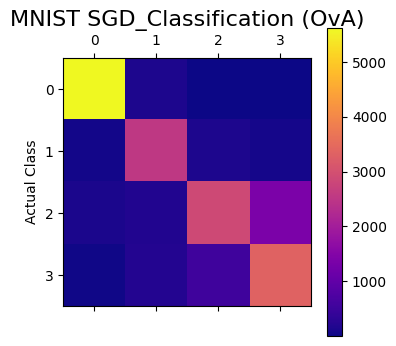

In [75]:

def plot_confusion_matrix(matrix,filename=None):
    """
    Grafica una matriz de confusión.

    Parámetros:
    - matriz (array-like): La matriz de confusión a visualizar.
    - nombre_archivo (str, opcional): Si se proporciona, guarda la gráfica en el archivo especificado.

    Retorna:
    Ninguno
    """
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap='plasma')
    fig.colorbar(cax)
    ax.set_title('MNIST SGD_Classification (OvA)',fontsize=16)
    ax.xaxis.set_ticks(np.arange(0, 4, 1))
    ax.yaxis.set_ticks(np.arange(0, 4, 1))
    ax.set_ylabel('Actual Class')
    if filename != None:
        plt.savefig(filename)
    plt.show()
    
plot_confusion_matrix(conf_mx_balanced,filename='conf_matrix.png')

In [76]:
#Calcula la suma de cada fila en la matriz de confusión balanceada
row_sums = conf_mx_balanced.sum(axis=1, keepdims=True)

#Normaliza la matriz de confusión dividiendo cada elemento por la suma correspondiente de la fila
#Esto proporciona la proporción de predicciones correctas para cada clase
norm_conf_mx = conf_mx_balanced / row_sums

#Muestra la fila normalizada correspondiente a la primera clase
norm_conf_mx[0, :]


array([9.73324095e-01, 2.51169236e-02, 1.03932098e-03, 5.19660488e-04])

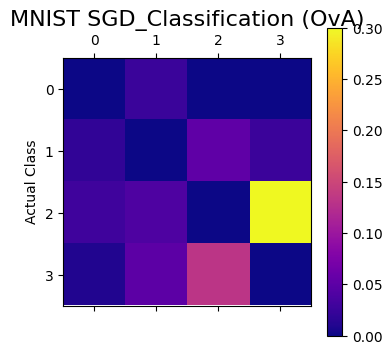

array([[0.        , 0.02511692, 0.00103932, 0.00051966],
       [0.01949663, 0.        , 0.0517547 , 0.02658632],
       [0.0292887 , 0.03985906, 0.        , 0.30037437],
       [0.00965484, 0.04948105, 0.1322713 , 0.        ]])

In [77]:
#remove data from matrix diagonal
np.fill_diagonal(norm_conf_mx, 0)
plot_confusion_matrix(norm_conf_mx,filename='conf_matrix_errors.png')
norm_conf_mx

## sklearn.neighbors.KNeighborsClassifier

In [78]:
unique_values_count_balanced = balanced_df['Room_Occupancy_Count'].value_counts()
print(unique_values_count_balanced)

Room_Occupancy_Count
0    8228
2    6468
3    5946
1    4042
Name: count, dtype: int64


In [79]:
#Separar las características y la variable objetivo
X_knn = balanced_df.drop('Room_Occupancy_Count', axis=1)
y_knn = balanced_df['Room_Occupancy_Count']

#Dividir los datos en conjuntos de entrenamiento y validación
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_knn, y_knn, test_size=0.3, random_state=42
)

#Identificar características numéricas
numeric_features = X_knn.select_dtypes(include=['number']).columns

#Crear un preprocesador para las características numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

#Combinar transformadores en un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

#Crear el pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=15))
])

#Entrenar el modelo utilizando el pipeline
pipeline.fit(X_train_knn, y_train_knn)

#Realizar predicciones en el conjunto de validación
y_pred_knn = pipeline.predict(X_test_knn)

### Evaluación de Modelo

In [80]:
#Evaluate the model
accuracy = accuracy_score(y_test_knn, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test_knn, y_pred_knn)
classification_report_str = classification_report(y_test_knn, y_pred_knn)


print("\nConfusion Matrix:")
print(conf_matrix_knn)
print("\nClassification Report:")
print(classification_report_str)
#If you want to extract specific metrics like recall, precision, etc.
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_knn, y_pred_knn, average='weighted')  #Use 'weighted' for multiclass
print(f"Precision: {precision *100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1_score*100:.2f}%")
print(f'Accuracy: {accuracy * 100:.2f}%')

cv_scores = cross_val_score(pipeline, X_knn, y_knn, cv=5, scoring='accuracy')
print('Cross-Validation Scores:', cv_scores)

#Evaluate the model
mse = mean_squared_error(y_test_knn, y_pred_knn)
print(f"Mean Squared Error: {mse}")

r_squared_knn = r2_score(y_test_knn, y_pred_knn)
print(f' R^2: {r_squared_knn*100:.2f}%')

n = len(y_test_knn)
numero_columns = df.shape[1]
k = numero_columns - 1 #se le resta 1 por que esta room_occupancy_count en el df
adjusted_r_squared_knn = 1 - ((1 - r_squared_knn) * (n - 1) / (n - k - 1))
print(f' R^2 Ajustado: {adjusted_r_squared_knn*100: .2f}%')



Confusion Matrix:
[[2437    8    8    2]
 [   0 1205   15    1]
 [   0   13 1899   15]
 [   0   14   68 1721]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2455
           1       0.97      0.99      0.98      1221
           2       0.95      0.99      0.97      1927
           3       0.99      0.95      0.97      1803

    accuracy                           0.98      7406
   macro avg       0.98      0.98      0.98      7406
weighted avg       0.98      0.98      0.98      7406

Precision: 98.09%
Recall: 98.06%
F1 Score: 98.06%
Accuracy: 98.06%
Cross-Validation Scores: [0.9627304  0.95969212 0.86935386 0.98278307 0.98196921]
Mean Squared Error: 0.030920874966243586
 R^2: 97.78%
 R^2 Ajustado:  97.78%


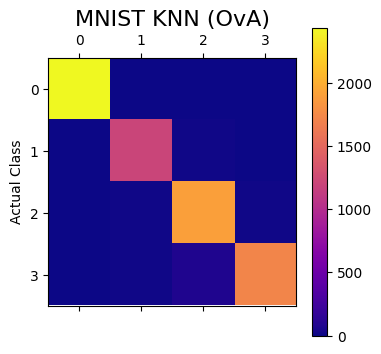

In [81]:
def plot_confusion_matrix_knn(matrix,filename=None):
    """If you prefer color and a colorbar
    """
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap='plasma')
    fig.colorbar(cax)
    ax.set_title('MNIST KNN (OvA)',fontsize=16)
    ax.xaxis.set_ticks(np.arange(0, 4, 1))
    ax.yaxis.set_ticks(np.arange(0, 4, 1))
    ax.set_ylabel('Actual Class')
    if filename != None:
        plt.savefig(filename)
    plt.show()
#Plot the confusion matrix for KNeighborsClassifier
plot_confusion_matrix_knn(conf_matrix_knn, filename='conf_matrix_knn.png')

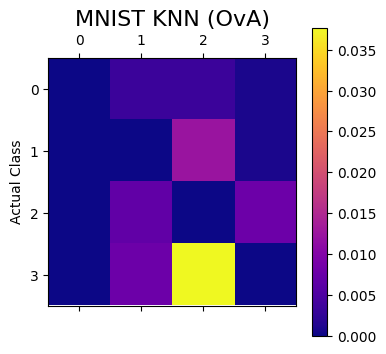

array([[0.        , 0.00325866, 0.00325866, 0.00081466],
       [0.        , 0.        , 0.01228501, 0.000819  ],
       [0.        , 0.00674624, 0.        , 0.00778412],
       [0.        , 0.00776484, 0.03771492, 0.        ]])

In [82]:
row_sums_knn = conf_matrix_knn.sum(axis=1, keepdims=True)
norm_conf_mx_knn = conf_matrix_knn / row_sums_knn

norm_conf_mx_knn[0,:]

#remove data from matrix diagonal
np.fill_diagonal(norm_conf_mx_knn, 0)
plot_confusion_matrix_knn(norm_conf_mx_knn,filename='conf_matrix_errors_knn.png')
norm_conf_mx_knn

In [83]:
param_grid_knn = {
    'classifier__n_neighbors': [5, 10, 15, 20],  #Número de vecinos
    'classifier__weights': ['uniform', 'distance'],  #Peso de los vecinos
}

#Crea el pipeline con KNeighborsClassifier
pipeline_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

#Inicializa el objeto GridSearchCV
grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='accuracy')

#Entrena el modelo con la búsqueda de hiperparámetros
grid_search_knn.fit(X_train_knn, y_train_knn)

#Obtiene los mejores parámetros y el mejor estimador después de la búsqueda
best_params_knn = grid_search_knn.best_params_
best_estimator_knn = grid_search_knn.best_estimator_

print("Mejores Parámetros para KNeighborsClassifier:", best_params_knn)


Mejores Parámetros para KNeighborsClassifier: {'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}


In [84]:
#Reemplaza el modelo original con el mejor estimador después de la búsqueda
knn_classifier = best_estimator_knn

#Realiza predicciones en el conjunto de prueba utilizando el mejor estimador
y_pred_knn_gridsearch = knn_classifier.predict(X_test_knn)

#Evalúa el modelo con las predicciones del conjunto de prueba
accuracy_knn_gridsearch = accuracy_score(y_test_knn, y_pred_knn_gridsearch)

print(f'Accuracy after GridSearchCV for KNeighborsClassifier: {accuracy_knn_gridsearch * 100:.2f}%')


Accuracy after GridSearchCV for KNeighborsClassifier: 99.92%
